<center>

 # **ACIT 4610 Mid - Tearm Portfolio Project 1**

 ## **Vehicle Routing Problem Using Quantum - Inspired Evolutionary Algorithms**

 ## **Group nr: 3**

</center>

## **1.Data Ingestion and Setup**

- import all necessary libraries and dependencies
- Load customer data
- Compute depot location
- define distance matrix

In [45]:
import math, random
from typing import NamedTuple, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Importing customers from csv file

In [34]:
def load_cvrplib_instance(path: str):
    with open(path, "r") as f:
        lines = f.readlines()

    coords = {}
    demands = {}
    capacity = None
    depot = None

    section = None
    for line in lines:
        line = line.strip()
        if line.startswith("CAPACITY"):
            capacity = int(line.split(":")[1])
        elif line.startswith("NODE_COORD_SECTION"):
            section = "coords"
            continue
        elif line.startswith("DEMAND_SECTION"):
            section = "demands"
            continue
        elif line.startswith("DEPOT_SECTION"):
            section = "depot"
            continue
        elif line.startswith("EOF"):
            break

        # Parse based on section
        if section == "coords" and line:
            idx, x, y = line.split()
            coords[int(idx)] = (float(x), float(y))
        elif section == "demands" and line:
            idx, d = line.split()
            demands[int(idx)] = int(d)
        elif section == "depot" and line and line != "-1":
            depot = int(line)

    # Convert to lists
    customer_ids = [i for i in coords if i != depot]
    customers = [coords[i] for i in customer_ids]
    demand_list = [demands[i] for i in customer_ids]

    return coords[depot], customers, demand_list, capacity


In [35]:
depot, customers, demands, capacity = load_cvrplib_instance("instances/X-n101-k25.vrp")

print("Depot:", depot)
print("Number of customers:", len(customers))
print("First 5 customers:", customers[:5])
print("First 5 demands:", demands[:5])
print("Vehicle capacity:", capacity)

Depot: (365.0, 689.0)
Number of customers: 100
First 5 customers: [(146.0, 180.0), (792.0, 5.0), (658.0, 510.0), (461.0, 270.0), (299.0, 531.0)]
First 5 demands: [38, 51, 73, 70, 58]
Vehicle capacity: 206


Preparing a customer coordinates list

In [36]:
# Defining distance matrix
def euclidean(a, b):
    return math.hypot(a[0]- b[0], a[1] - b[1])

def distance_matrix(depot, customers):
    pts = [tuple(depot)] + [tuple(c) for c in customers]
    n = len(pts)
    dmat = np.zeros((n,n), dtype = float)
    for i in range(n):
        for j in range(n):
            if i == j:
                dmat[i, j] = 0.0
            else:
                dmat[i, j] = euclidean(pts[i], pts[j])

    return dmat

# coords_df is a pandas data frame.
# customers is a zipped file. Tuples in a list with all coordinates

## **2. Chromosome Representation and VRP Instances**


- VRP instances setup (small, medium , large)
- Individual route representation
- Permutation and cut points encoding

In [37]:
class VRPInstance:
    def __init__(self, depot, vehicles, customers):
        self.depot = depot
        self.customers = customers
        self.vehicles = vehicles

# Representation in order to choose the chromosome format for the VRP.
class Individual(NamedTuple):
    perm: List[int]  # visit order
    cuts: List[int]  # split it to routes for each vehicle

# random intializer
def random_individual(N: int, V: int, rng:random.Random) -> Individual:

    # random permutation of all customers
    if V > N:
        raise ValueError("the number of vehicles cannot exceed number of customers.")

    perm = list(range(1, N+1))
    rng.shuffle(perm)

    #choose exactly V-1 unique cut positions
    # here maybe an error handler later

    cuts = sorted(rng.sample(range(1, N), V-1))  # random cuts same number as number of vehicles  <----###### Put min vehicles???

    return Individual(perm=perm, cuts=cuts)


# decode into actual routes
def decode_routes(ind: Individual, V: int, demands: List[int], capacity: int):
    perm = ind.perm
    cuts = ind.cuts
    routes = []
    prev = 0

    for c in cuts:
        routes.append(perm[prev:c])
        prev = c
    routes.append(perm[prev:])

    # Compute loads for each route
    route_loads = []
    for r in routes:
        load = sum(demands[i-1] for i in r)
        route_loads.append(load)

    return routes, route_loads

def route_distance(route: List[int], dmat) -> float: # distance per vehicle
    total = 0.0
    prev = 0
    for c in route:
        total += dmat[prev, c]
        prev = c
    total += dmat[prev, 0] # final route to back to depot
    return float(total)

def route_lengths(ind: Individual, dmat, V: int, demands: List[int], capacity: int):
    routes, route_loads = decode_routes(ind, V, demands, capacity)

    lengths = []
    for r, load in zip(routes, route_loads):
        if load > capacity:
            lengths.append(1e6)
        else:
            lengths.append(route_distance(r, dmat))
    return lengths

def total_distance(ind: Individual, dmat, V: int, demands: List[int], capacity: int):#
    routes, route_loads = decode_routes(ind, V, demands, capacity)

    total = 0.0
    for r, load in zip(routes, route_loads):
        if load > capacity:
            total += 1e6
        else:
            total += route_distance(r, dmat)

    # distance of all the routes in a scenario
    return total

def objective_total_distance(ind, dmat, V, demands, capacity):
    return sum(route_lengths(ind, dmat, V, demands, capacity))

def objective_balance_std(ind, dmat, V, demands, capacity):
    lengths = route_lengths(ind, dmat, V, demands, capacity)
    return float(np.std(lengths))


## **3. Genetic Algorithm Design**
### **3.1 GA Operators**
- selection
- crossover
- mutation


In [38]:
def evaluate(ind: Individual, dmat, V: int, demands: List[int], capacity: int):
    f1 = objective_total_distance(ind, dmat, V, demands, capacity)
    f2 = objective_balance_std(ind, dmat, V, demands, capacity)
    return (f1, f2)

def fast_non_dominated_sort(objectives):
    S = [[] for _ in range(len(objectives))]
    n = [0] * len(objectives)
    rank = [0] * len(objectives)

    fronts = [[]]
    for p in range(len(objectives)):
        for q in range(len(objectives)):
            if (objectives[p] <= objectives[q] and objectives[p][1] <= objectives[q][1]) \
                    and (objectives[p][0] < objectives[q][0] or objectives[p][1] < objectives[q][1]):
                S[p].append(q)
            elif (objectives[q][0] <= objectives[p][0] and objectives[q][1] <= objectives[p][1]) \
                    and (objectives[q][0] < objectives[p][0] or objectives[q][1] < objectives[p][1]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    next_front.append(q)
        i += 1
        fronts.append(next_front)

    return fronts[:-1]

def crowding_distance(front, objectives):
    distance = [0.0] * len(front)
    num_objectives = len(objectives[0])

    for m in range(num_objectives):
        values = [(objectives[i][m], i) for i in front]
        values.sort()
        fmin, fmax = values[0][0], values[-1][0]
        if fmax == fmin:
            continue
        distance[front.index(values[0][1])] = float("inf")
        distance[front.index(values[-1][1])] = float("inf")
        for k in range(1, len(front)-1):
            prev_val, prev_idx = values[k-1]
            next_val, next_idx = values[k+1]
            distance[front.index(values[k][1])] += (next_val - prev_val) / (fmax - fmin)

    return distance

def tournament_selection_idx(fitnesses: List[float], k: int, rng: random.Random) -> int:
    # return index of selected parent via k-tournament where higher fitness wins
    cand = [rng.randrange(len(fitnesses)) for i in range(k)]
    return max(cand, key=lambda i: fitnesses[i])

def order_crossover(p1: List[int], p2: List[int], rng: random.Random) -> Tuple[List[int], List[int]]:
    # permutation order crossover between two parents
    n = len(p1)
    a, b = sorted([rng.randrange(n), rng.randrange(n)])
    def ox(a, b, x, y):
        child = [None]*n
        child[a:b+1] = x[a:b+1]
        fill = [g for g in y if g not in child]
        pos = 0
        for i in range(n):
            if child[i] is None:
                child[i] = fill[pos]
                pos +=1
            else:
                child[i] = x[i]
        return child
    return ox(a,b,p1,p2), ox(a,b,p2,p1)

def repair_cuts(cuts: List[int], N: int, V:int, rng: random.Random) -> List[int]:
    clamped = [min(max(1, c), N-1) for c in cuts] #clamp cuts to valid range
    uniq = sorted(set(clamped))
    need = (V-1)- len(uniq)
    if need > 0:
        #fill missing positions
        pool = [c for c in range(1,N) if c not in uniq]
        add = rng.sample(pool, need)
        uniq = sorted(uniq + add)
    elif need < 0:
        # trim number of cuts if to many
        drop = rng.sample(range(len(uniq)), -need)
        keep = [i for i in range(len(uniq)) if i not in drop]
        uniq = [uniq[i] for i in keep]
    return uniq

def cuts_crossover(c1: List[int], c2: List[int], N: int, V: int, rng: random.Random) -> Tuple[List[int], List[int]]:
    # one point crossover between sorted cuts and then repair
    if not c1 and not c2:
        return [], []
    a = rng.randrange(0, max(len(c1), 1))
    ch1 = sorted(c1[:a] + c2[a:])
    ch2 = sorted(c2[:a] + c1[a:])
    ch1 = repair_cuts(ch1, N, V, rng)
    ch2 = repair_cuts(ch2, N, V, rng)
    return ch1, ch2

def swap_mutation_perm(p: List[int], p_mut:float, rng: random.Random) -> List[int]:
    #swap mutation for permutation
    q = p[:]
    if rng.random() < p_mut and len(q) >= 2:
        i , j = rng.sample(range(len(q)), 2)
        q[i], q[j] = q[j], q[i]
    return q

def jitter_mutation_cuts(cuts: List[int], N:int, V:int, p_mut: float, rng: random.Random) -> List[int]:
    # jitter mutation for cuts positions
    q = cuts[:]
    if rng.random() < p_mut and q:
        i = rng.randrange(len(q))
        shift = rng.choice([1,-1])
        q[i] = min(max(1, q[i] + shift), N-1)
    return repair_cuts(q, N, V, rng)

def repair_perm(perm, N):
    """Ensure permutation has exactly [1..N] once each."""
    seen = set()
    fixed = []
    for g in perm:
        if 1 <= g <= N and g not in seen:
            fixed.append(g)
            seen.add(g)
    missing = [g for g in range(1, N+1) if g not in seen]
    fixed.extend(missing)
    return fixed

def greedy_nearest_neighbor(N, V, demands, capacity, dmat, rng):
    unvisited = set(range(1, N+1))  # customers labeled 1..N
    perm = []
    cuts = []
    load = 0
    current = 0  # depot

    while unvisited:
        # Find nearest feasible customer
        feasible_customers = [c for c in unvisited if load + demands[c-1] <= capacity]
        if not feasible_customers:
            # capacity exceeded → cut route
            cuts.append(len(perm))
            load = 0
            current = 0
            continue

        # choose nearest
        nearest = min(feasible_customers, key=lambda c: dmat[current, c])
        perm.append(nearest)
        unvisited.remove(nearest)
        load += demands[nearest-1]
        current = nearest

    # Ensure cuts has V-1 positions (pad or trim)
    while len(cuts) < V-1:
        cuts.append(rng.randint(1, N-1))
    cuts = sorted(cuts[:V-1])

    return Individual(perm=perm, cuts=cuts)

def init_population(N, V, demands, capacity, dmat, pop_size, rng, greedy_frac=0.3):
    pop = []
    greedy_count = int(pop_size * greedy_frac)

    # Greedy individuals
    for _ in range(greedy_count):
        pop.append(greedy_nearest_neighbor(N, V, demands, capacity, dmat, rng))

    # Random individuals
    for _ in range(pop_size - greedy_count):
        pop.append(random_individual(N, V, rng))

    return pop


### **3.2 GA Engine**

Main GA function to:

- initialize population
- loop over generations
- apply GA operations
- return best solution and history

In [39]:

def nsga2(dmat, N, V, demands, capacity, pop_size, generations, pc, pm_perm, pm_cuts, seed):
     rng = random.Random(seed)

     # Init population
     pop = init_population(N, V, demands, capacity, dmat, pop_size, rng, greedy_frac=0.3)
     objectives = [evaluate(ind, dmat, V, demands, capacity) for ind in pop]


     for gen  in range(generations):
        # Create offspring
        offspring = []
        while len(offspring) < pop_size:
            # Tournament selection
            i, j = rng.sample(range(len(pop)), 2)
            parent1 = pop[i]
            parent2 = pop[j]

             # Crossover
            if rng.random() < pc:
                # crossover permutations
                child_perm1, child_perm2 = order_crossover(parent1.perm, parent2.perm, rng)
                # crossover cuts
                child_cuts1, child_cuts2 = cuts_crossover(parent1.cuts, parent2.cuts, N, V, rng)

                c1 = Individual(perm=child_perm1, cuts=child_cuts1)
                c2 = Individual(perm=child_perm2, cuts=child_cuts2)
            else:
                # just copy parents
                c1 = Individual(perm=parent1.perm[:], cuts=parent1.cuts[:])
                c2 = Individual(perm=parent2.perm[:], cuts=parent2.cuts[:])


            # Mutation
                c1 = Individual(
                    perm=repair_perm(swap_mutation_perm(c1.perm, pm_perm, rng), N),
                    cuts=jitter_mutation_cuts(c1.cuts, N, V, pm_cuts, rng)
                )
                c2 = Individual(
                    perm=repair_perm(swap_mutation_perm(c2.perm, pm_perm, rng), N),
                    cuts=jitter_mutation_cuts(c2.cuts, N, V, pm_cuts, rng)
                )
            offspring.extend([c1, c2])

        for ind in pop:
            if sorted(ind.perm) != list(range(1, N+1)):
                print("⚠️ Invalid individual found!", ind.perm[:20])

        # Evaluate offspring
        offspring_objectives = [evaluate(ind, dmat, V, demands, capacity) for ind in offspring]

        # Combine parent + offspring
        combined = pop + offspring
        combined_objectives = objectives + offspring_objectives

        # Non-dominated sort
        fronts = fast_non_dominated_sort(combined_objectives)

        new_pop, new_obj = [], []
        for front in fronts:
            if len(new_pop) + len(front) <= pop_size:
                new_pop.extend([combined[i] for i in front])
                new_obj.extend([combined_objectives[i] for i in front])
            else:
                # Crowding distance for last partial front
                distances = crowding_distance(front, combined_objectives)
                sorted_front = [f for _, f in sorted(zip(distances, front), reverse=True)]
                remaining = pop_size - len(new_pop)
                new_pop.extend([combined[i] for i in sorted_front[:remaining]])
                new_obj.extend([combined_objectives[i] for i in sorted_front[:remaining]])
                break

        pop, objectives = new_pop, new_obj

     return pop, objectives




## **4.Experiment**

In [40]:
instances = [
    ("A-n32-k5.vrp", 5, "A"),   # small
    ("B-n78-k10.vrp", 10, "B"), # medium
    ("X-n101-k25.vrp", 25, "X") # large
]

param_sets = [
    {"pop_size": 50, "generations": 100, "pc": 0.7, "pm_perm": 0.2, "pm_cuts": 0.1},
    {"pop_size": 100, "generations": 200, "pc": 0.8, "pm_perm": 0.3, "pm_cuts": 0.15},
    {"pop_size": 200, "generations": 300, "pc": 0.9, "pm_perm": 0.4, "pm_cuts": 0.2}
]


In [41]:
def save_pareto_front(pop, objectives, filename="pareto_front.csv"):
    data = []
    for ind, (f1, f2) in zip(pop, objectives):
        data.append({
            "total_distance": f1,
            "balance_std": f2,
            "perm": ind.perm,
            "cuts": ind.cuts
        })
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"✅ Saved Pareto front to {filename}")

def plot_pareto_front(objectives, title="Pareto Front"):
    f1 = [obj[0] for obj in objectives]
    f2 = [obj[1] for obj in objectives]

    plt.scatter(f1, f2, alpha=0.6, label="Solutions")

    # Sort by total distance (f1)
    sorted_objs = sorted(objectives, key=lambda x: x[0])
    front_x = [obj[0] for obj in sorted_objs]
    front_y = [obj[1] for obj in sorted_objs]

    # Draw Pareto front line
    plt.plot(front_x, front_y, color="red", linewidth=0.1, label="Pareto front", zorder=1)

    plt.xlabel("Total Distance")
    plt.ylabel("Route Balance (std)")
    plt.title(title)
    plt.legend()
    plt.show()


In [42]:
def get_routes(ind, V, demands, capacity):
    routes, _ = decode_routes(ind, V, demands, capacity)
    return routes

def plot_routes(ind, depot, customers, V, demands, capacity, dmat, title="Best Solution"):
    routes = get_routes(ind, V, demands, capacity)

    plt.figure(figsize=(6,6))
    # Plot depot
    plt.scatter(depot[0], depot[1], c="red", marker="s", s=100, label="Depot")

    # Plot customers
    x_cust = [c[0] for c in customers]
    y_cust = [c[1] for c in customers]
    plt.scatter(x_cust, y_cust, c="blue", s=30, label="Customers")

    # Plot routes
    colors = plt.cm.tab20.colors  # 20 distinct colors
    for i, route in enumerate(routes):
        if not route:
            continue
        # Build coordinates: depot → customers → depot
        coords = [depot] + [customers[c-1] for c in route] + [depot]
        xs, ys = zip(*coords)
        plt.plot(xs, ys, '-', color=colors[i % len(colors)], linewidth=1, alpha=0.7, label=f"Vehicle {i+1}", zorder=1)

    plt.title(title)
    plt.legend(loc="best", fontsize=8)
    plt.show()


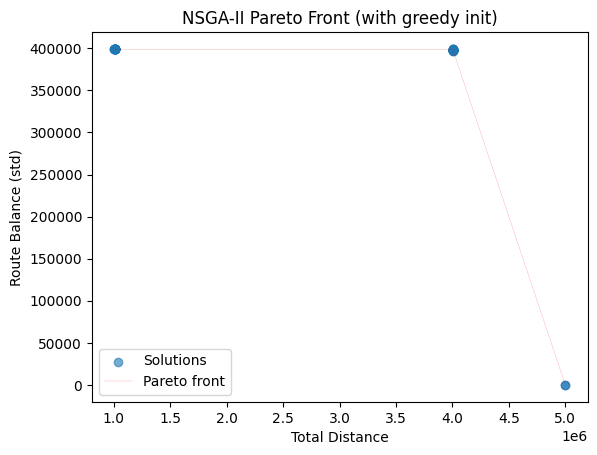

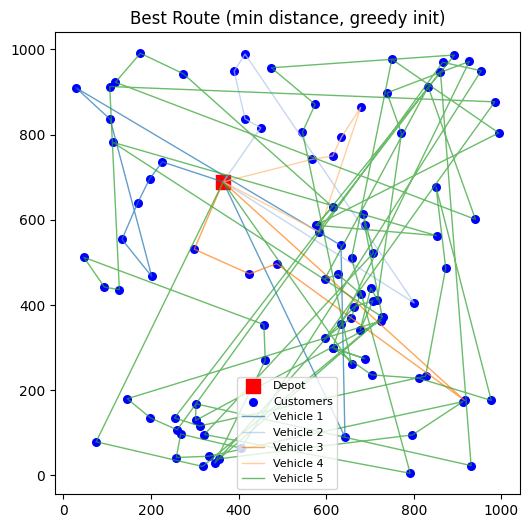

In [43]:
depot, customers, demands, capacity = load_cvrplib_instance("instances/X-n101-k25.vrp")

dmat = distance_matrix(depot, customers)
N, V = len(customers), 5

pop, objectives = nsga2(dmat, N, V, demands, capacity,
                        pop_size=50, generations=100,
                        pc=0.7, pm_perm=0.2, pm_cuts=0.1, seed=42)

plot_pareto_front(objectives, "NSGA-II Pareto Front (with greedy init)")

best_idx = min(range(len(objectives)), key=lambda i: objectives[i][0])
best_ind = pop[best_idx]

plot_routes(best_ind, depot, customers, V, demands, capacity, dmat,
            title="Best Route (min distance, greedy init)")




▶ Running A-n32-k5.vrp | Params 1 | Seed 1


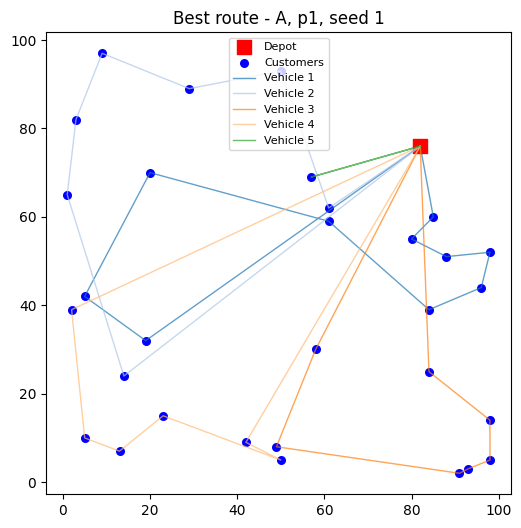

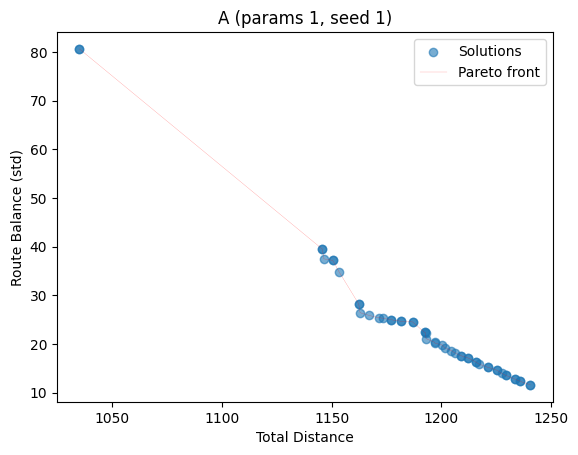

▶ Running A-n32-k5.vrp | Params 1 | Seed 42


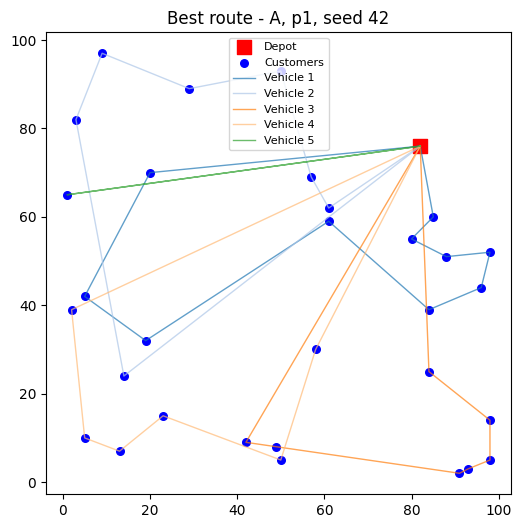

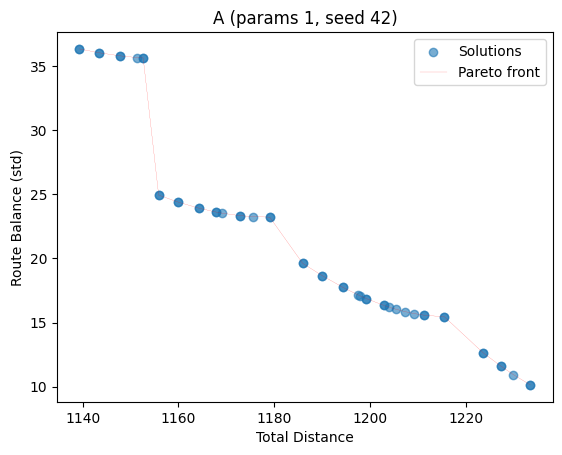

▶ Running A-n32-k5.vrp | Params 1 | Seed 99


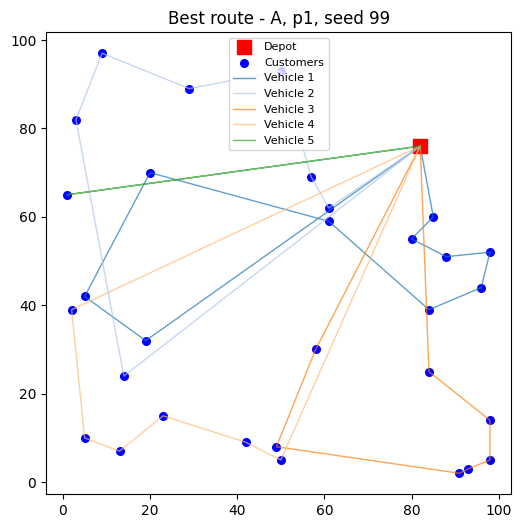

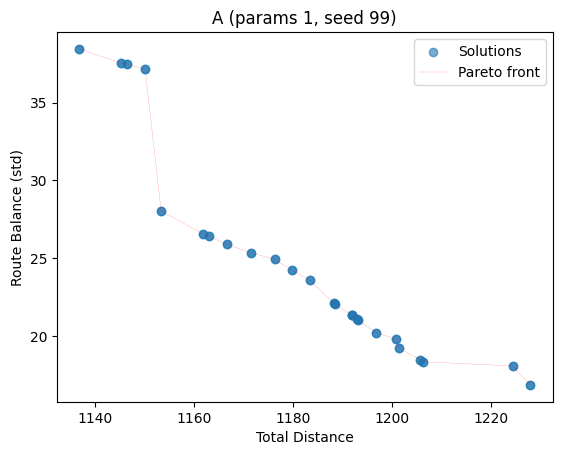

▶ Running A-n32-k5.vrp | Params 2 | Seed 1


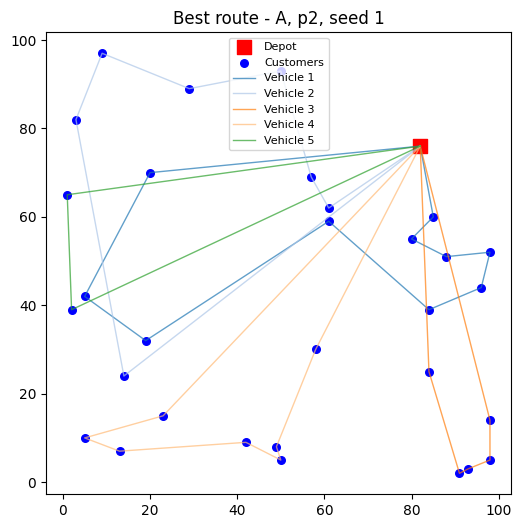

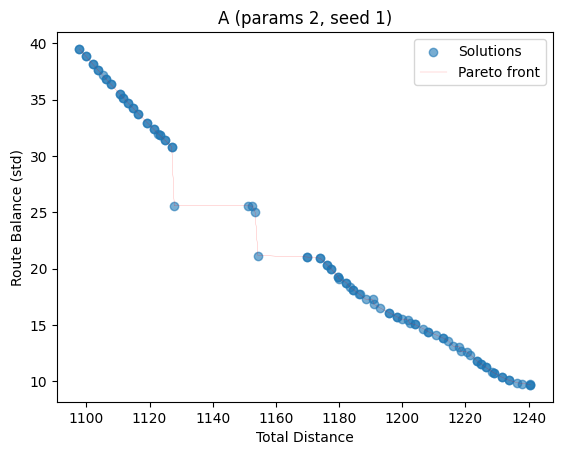

▶ Running A-n32-k5.vrp | Params 2 | Seed 42


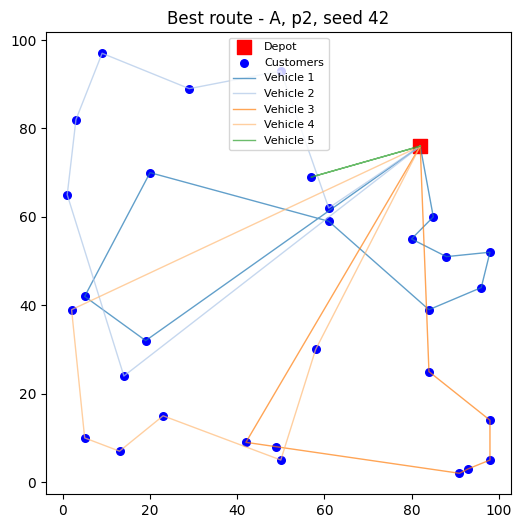

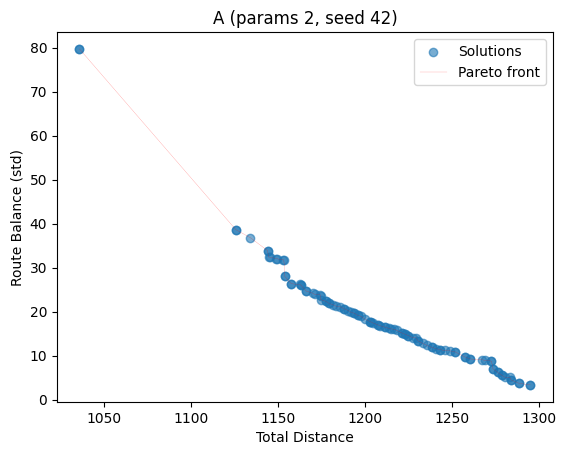

▶ Running A-n32-k5.vrp | Params 2 | Seed 99


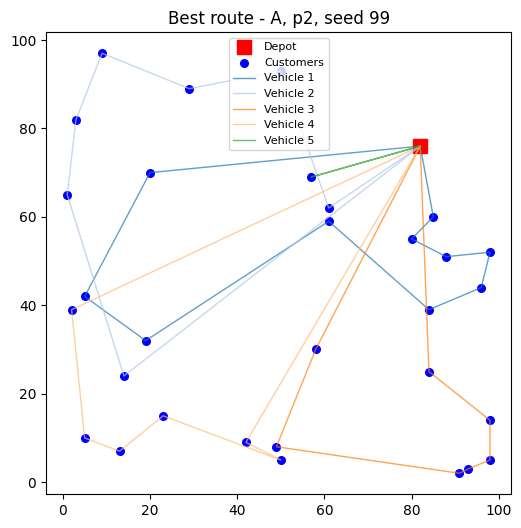

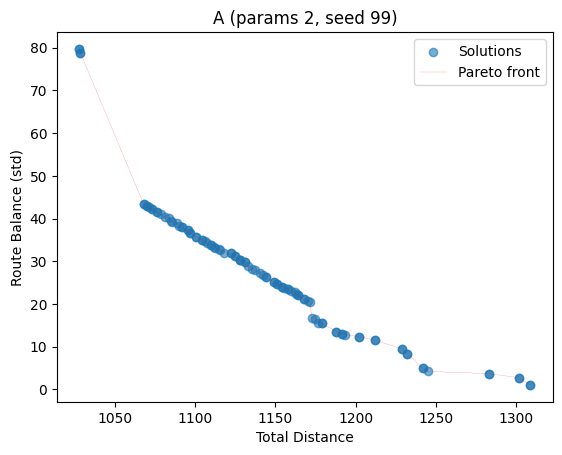

▶ Running A-n32-k5.vrp | Params 3 | Seed 1


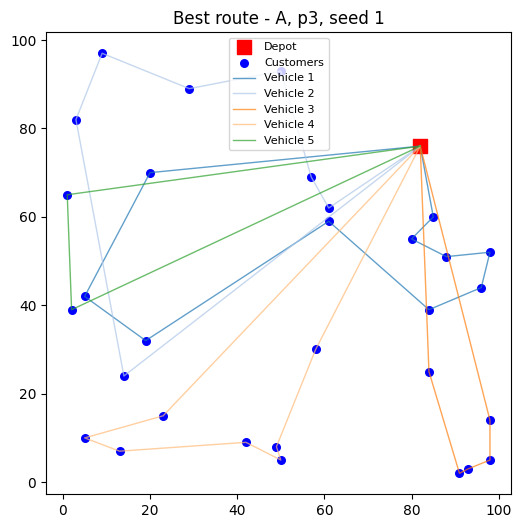

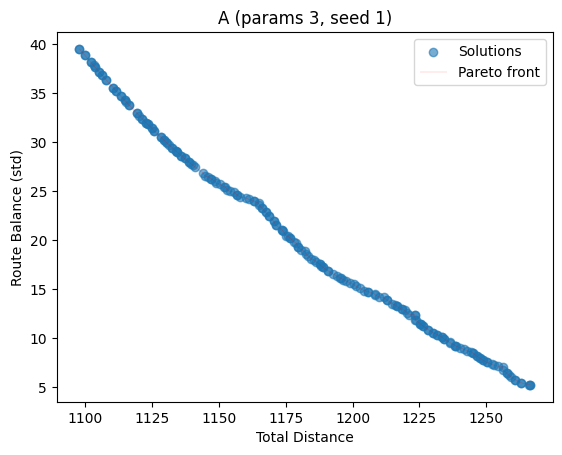

▶ Running A-n32-k5.vrp | Params 3 | Seed 42


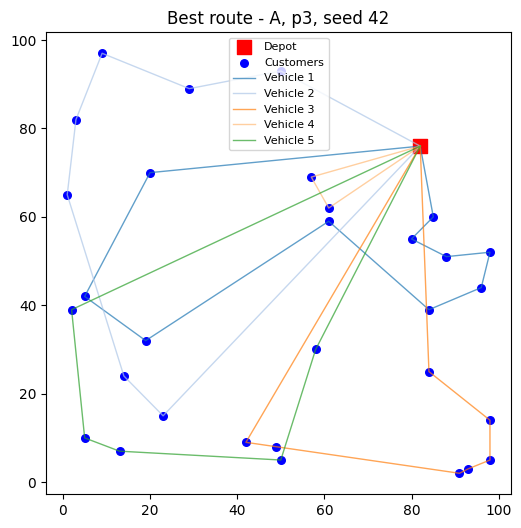

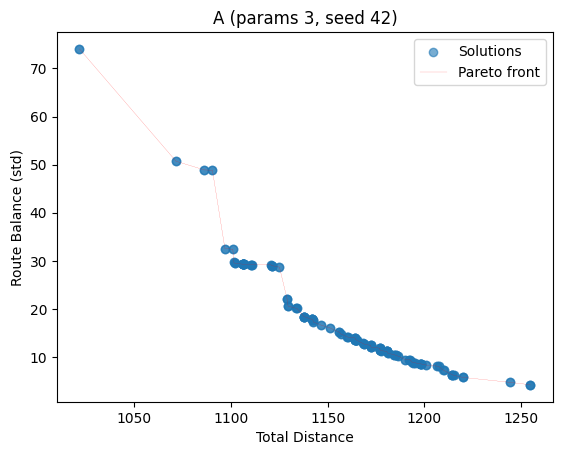

▶ Running A-n32-k5.vrp | Params 3 | Seed 99


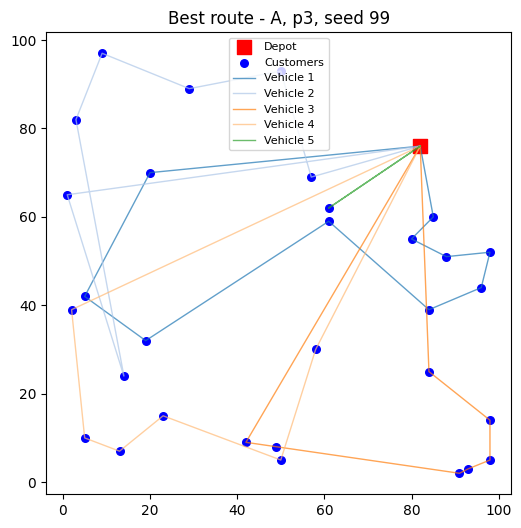

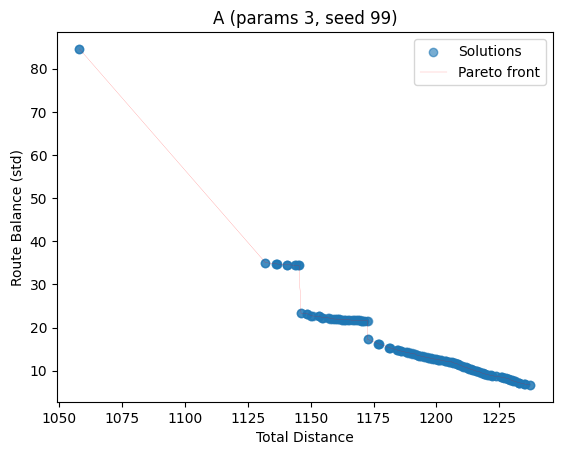

▶ Running B-n78-k10.vrp | Params 1 | Seed 1


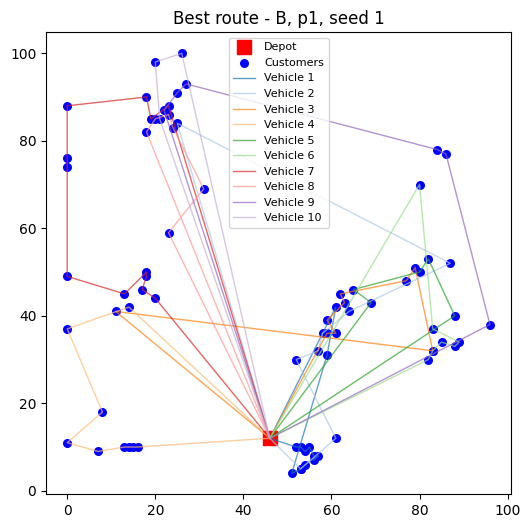

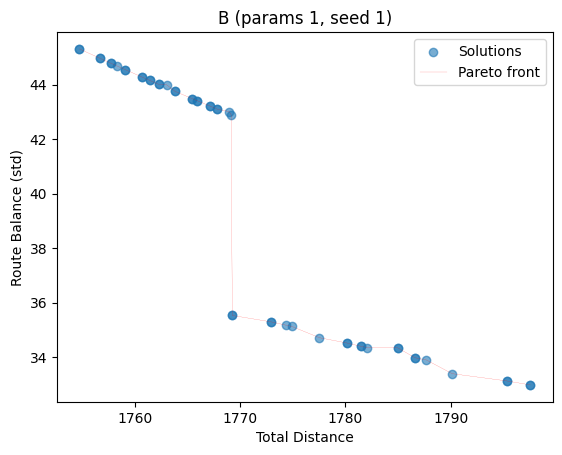

▶ Running B-n78-k10.vrp | Params 1 | Seed 42


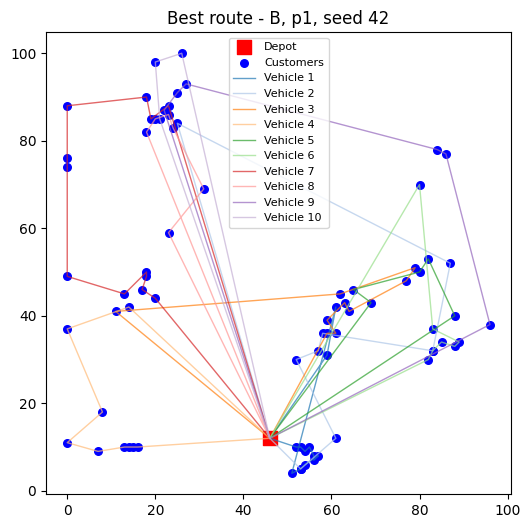

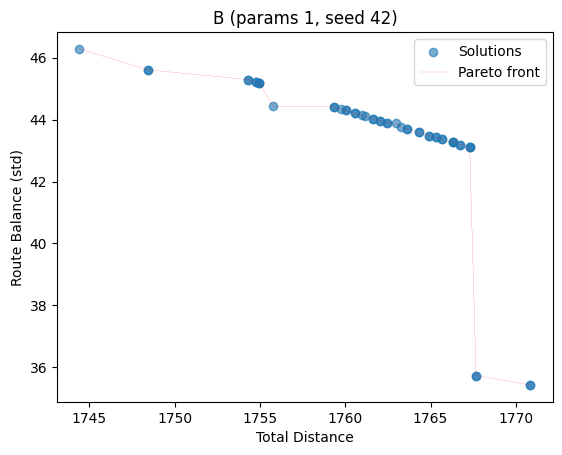

▶ Running B-n78-k10.vrp | Params 1 | Seed 99


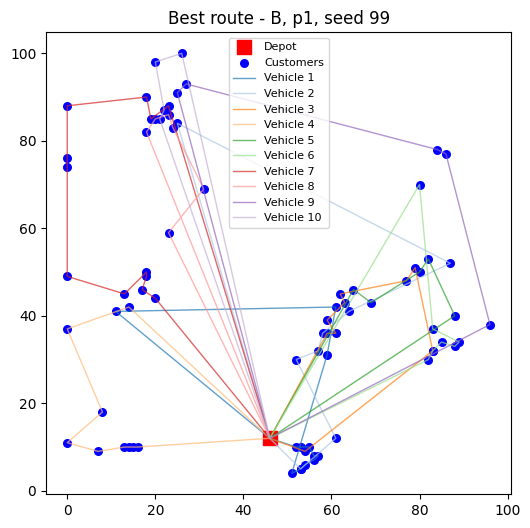

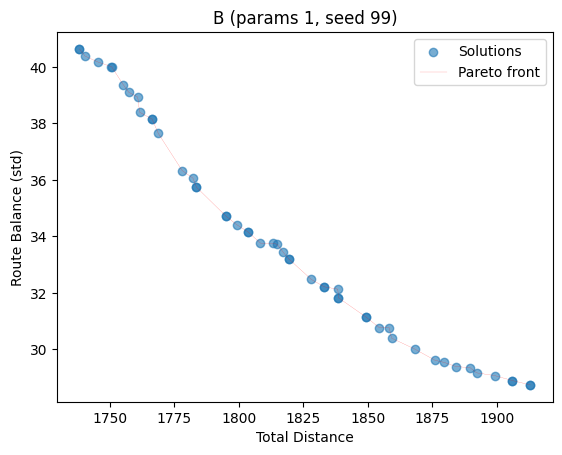

▶ Running B-n78-k10.vrp | Params 2 | Seed 1


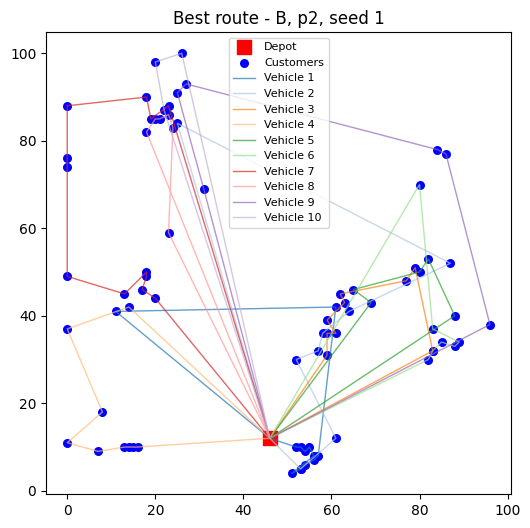

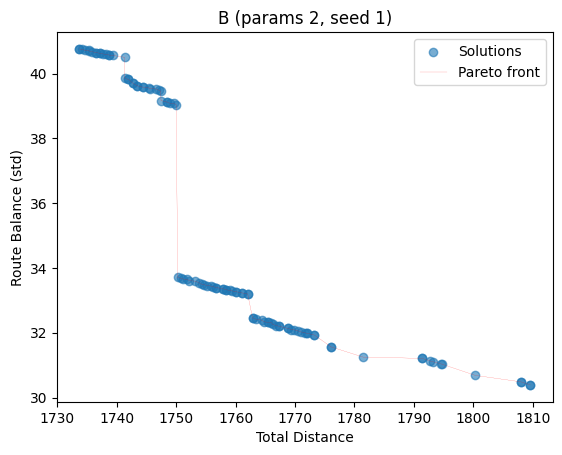

▶ Running B-n78-k10.vrp | Params 2 | Seed 42


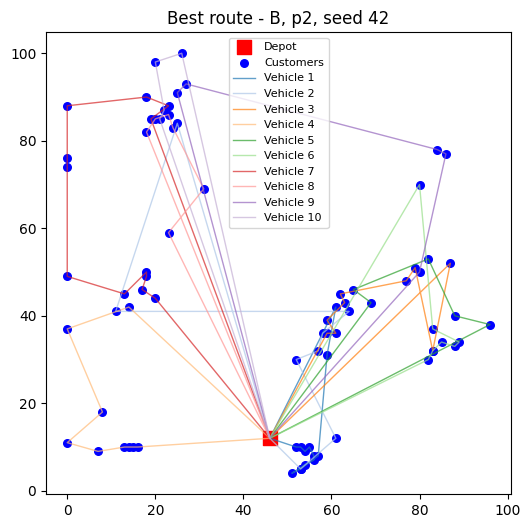

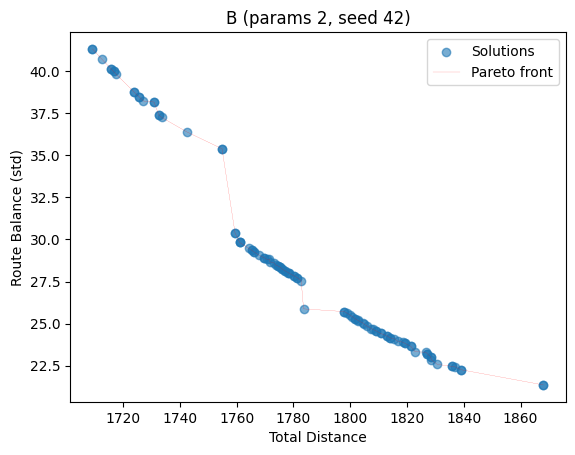

▶ Running B-n78-k10.vrp | Params 2 | Seed 99


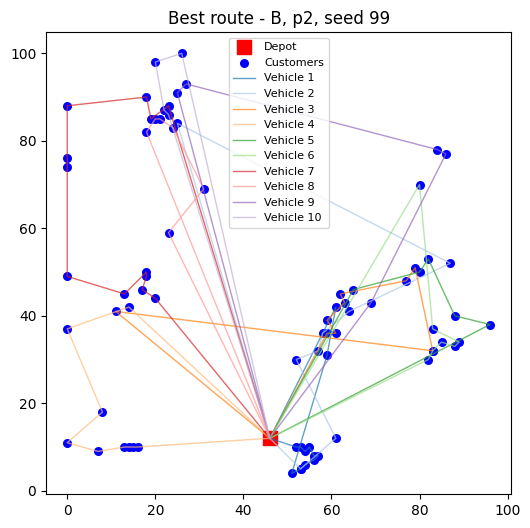

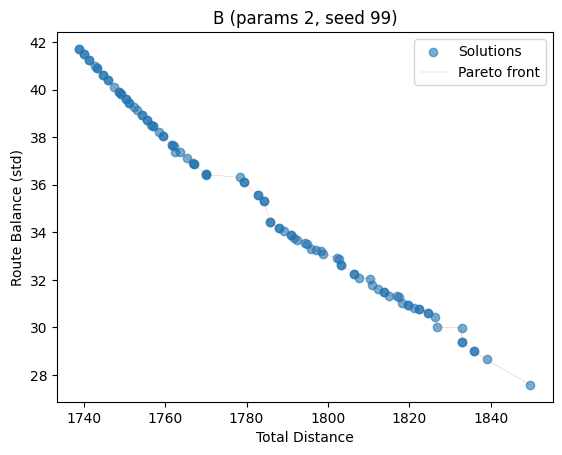

▶ Running B-n78-k10.vrp | Params 3 | Seed 1


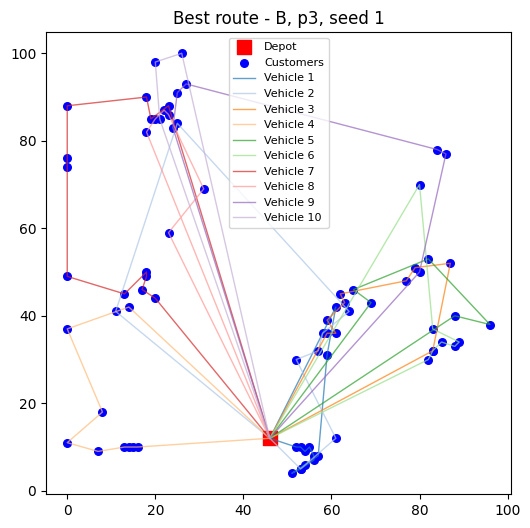

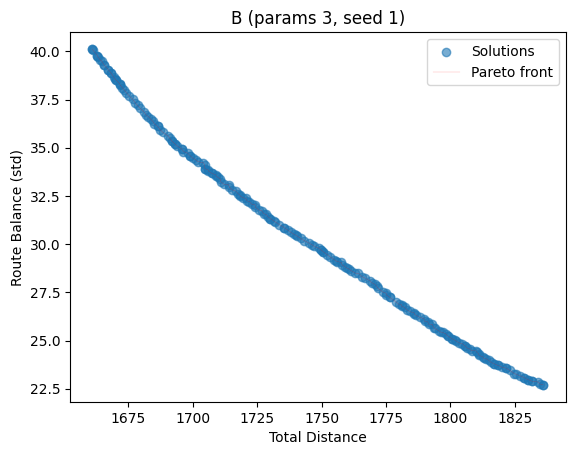

▶ Running B-n78-k10.vrp | Params 3 | Seed 42


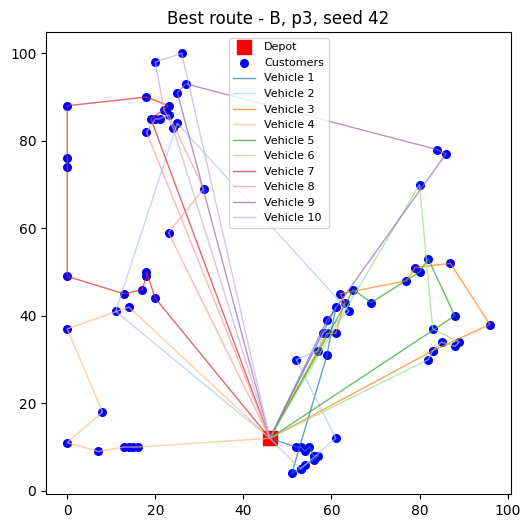

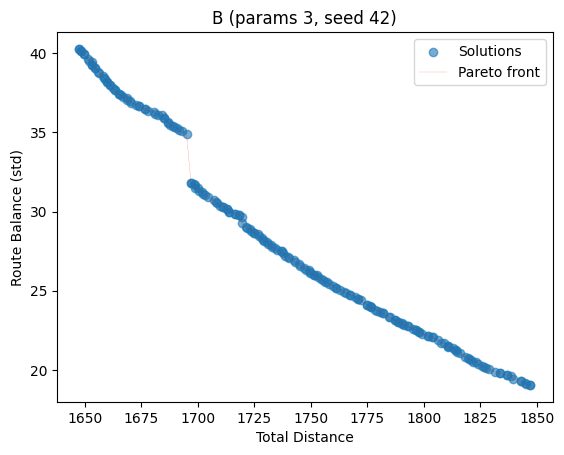

▶ Running B-n78-k10.vrp | Params 3 | Seed 99


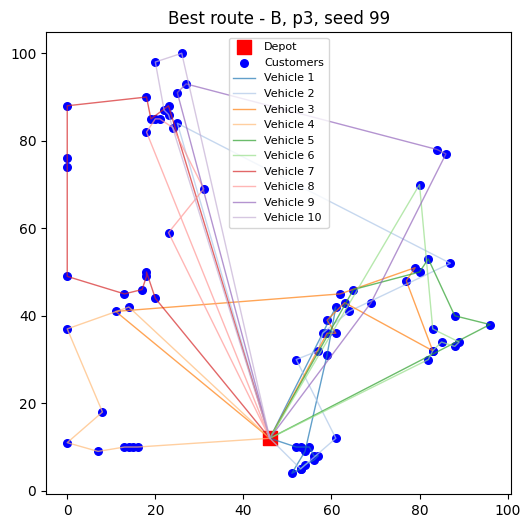

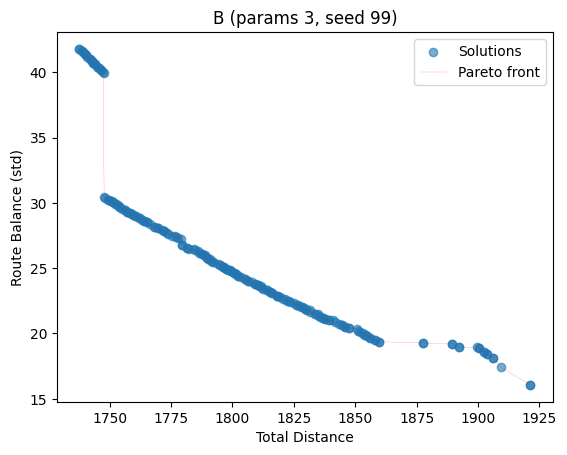

▶ Running X-n101-k25.vrp | Params 1 | Seed 1


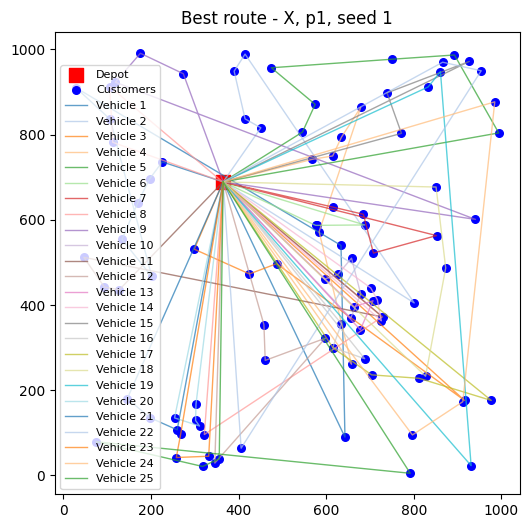

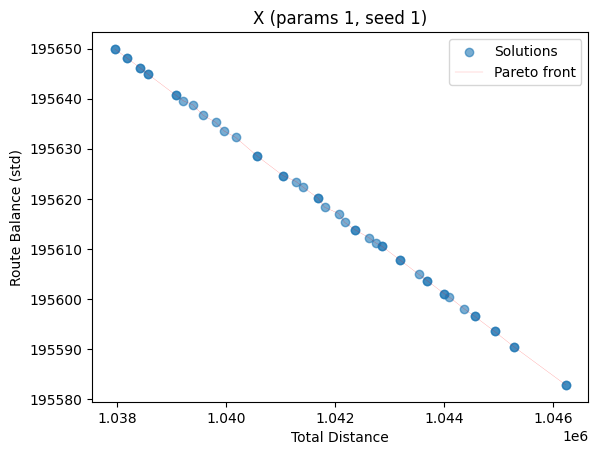

▶ Running X-n101-k25.vrp | Params 1 | Seed 42


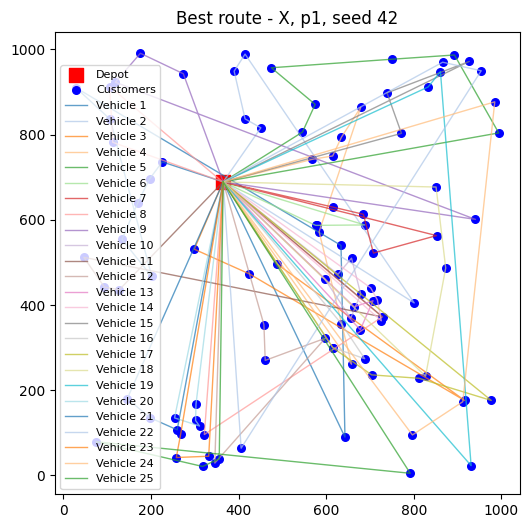

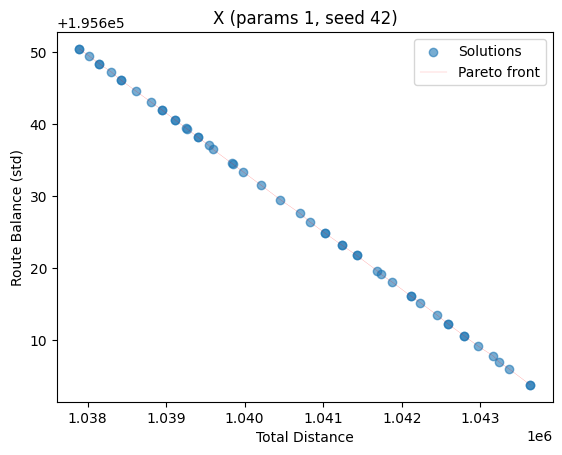

▶ Running X-n101-k25.vrp | Params 1 | Seed 99


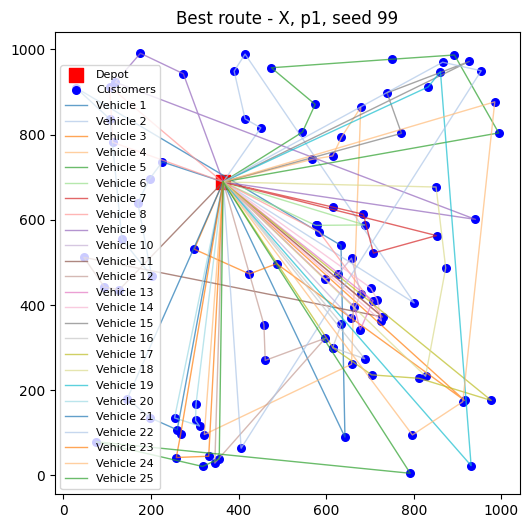

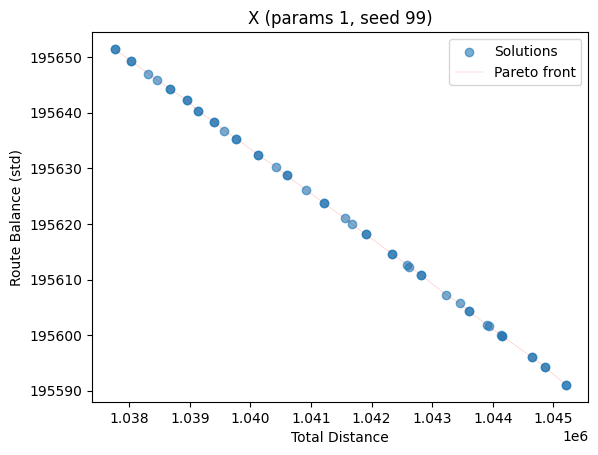

▶ Running X-n101-k25.vrp | Params 2 | Seed 1


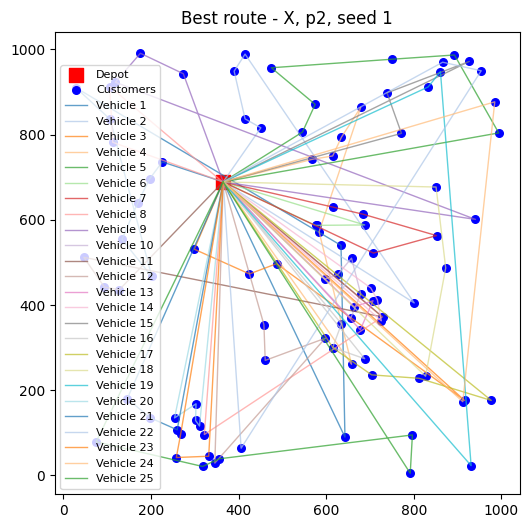

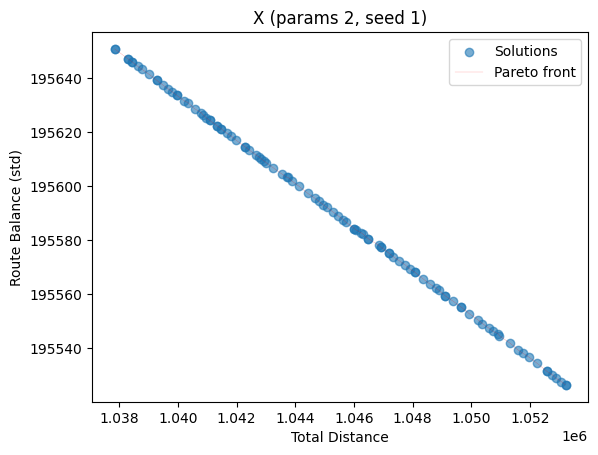

▶ Running X-n101-k25.vrp | Params 2 | Seed 42


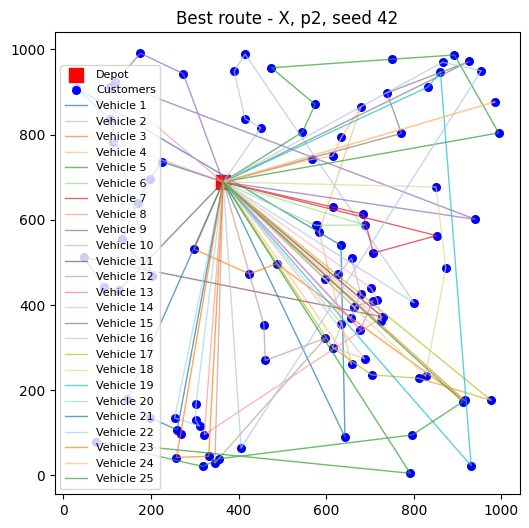

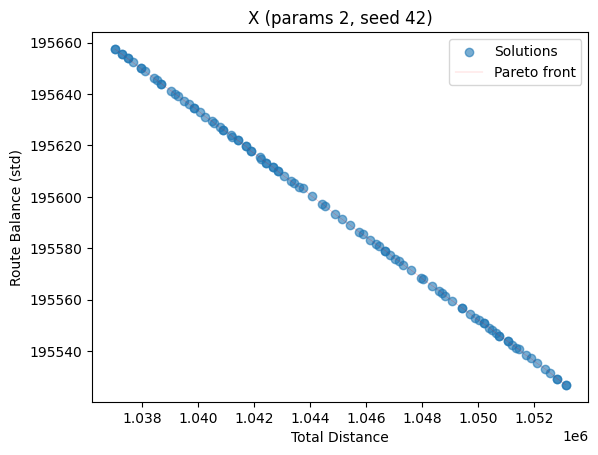

▶ Running X-n101-k25.vrp | Params 2 | Seed 99


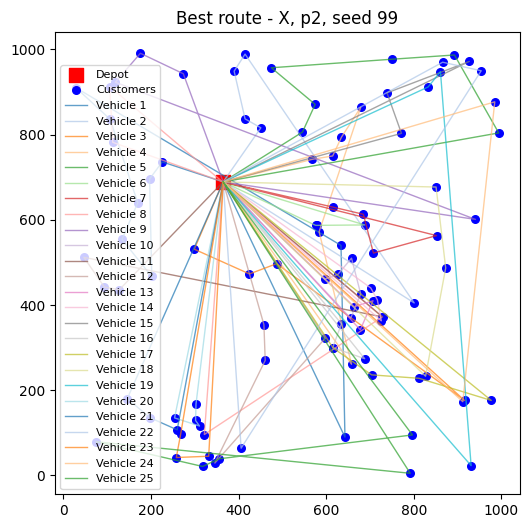

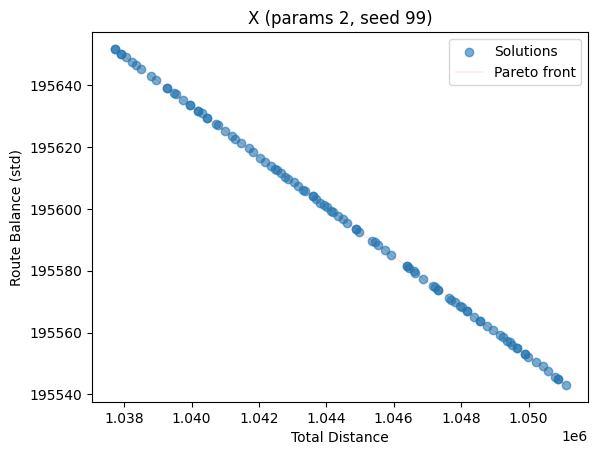

▶ Running X-n101-k25.vrp | Params 3 | Seed 1


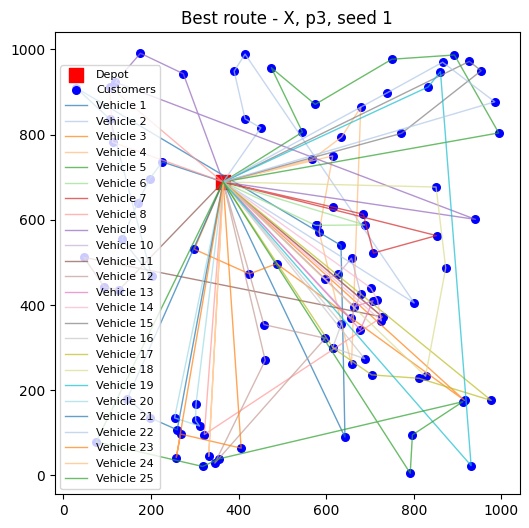

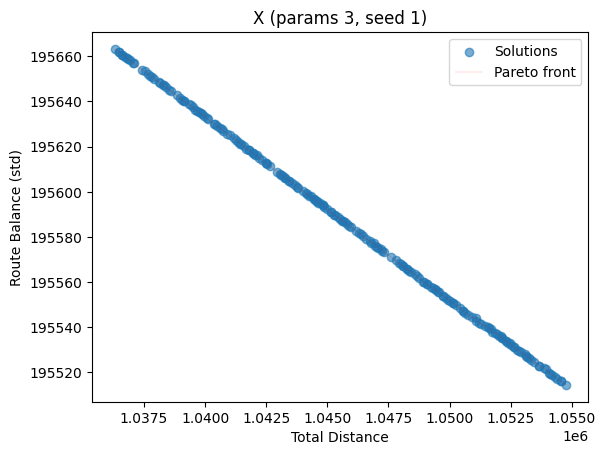

▶ Running X-n101-k25.vrp | Params 3 | Seed 42


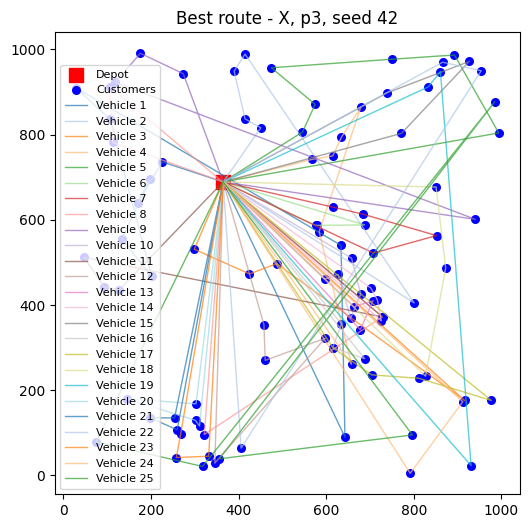

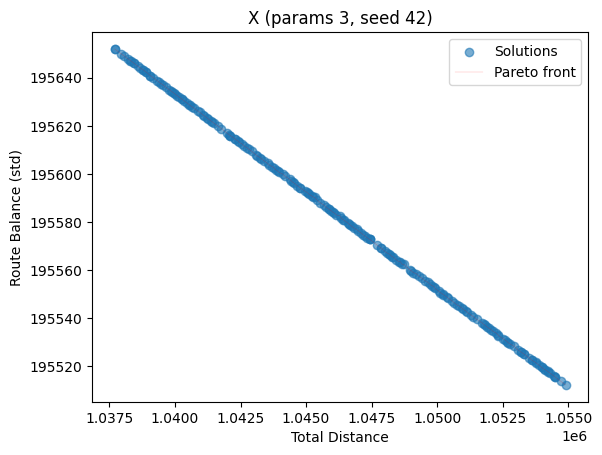

▶ Running X-n101-k25.vrp | Params 3 | Seed 99


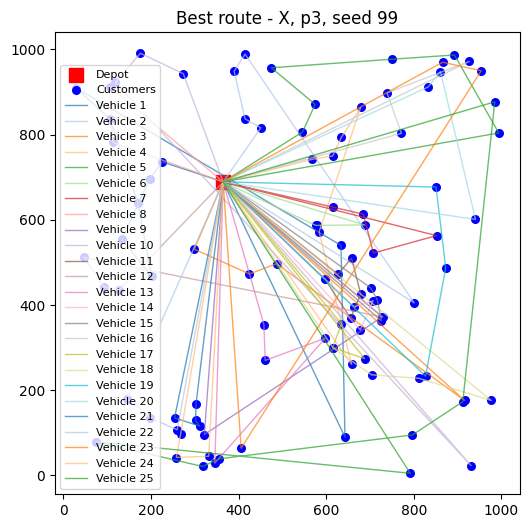

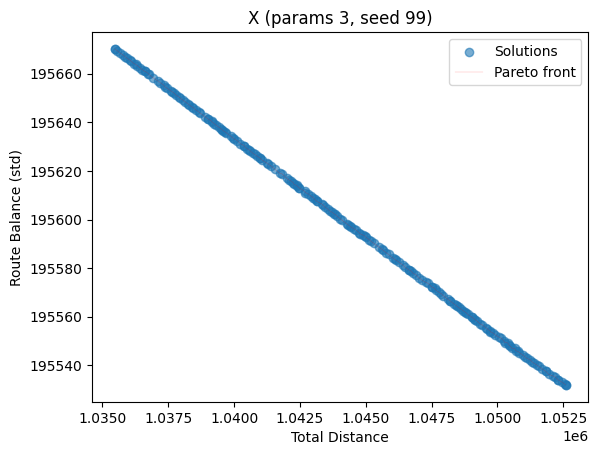

instance  param_set  seed  best_distance   best_balance
0         A          1     1   1.035156e+03      11.560114
1         A          1    42   1.139325e+03      10.138588
2         A          1    99   1.136772e+03      16.845857
3         A          2     1   1.097829e+03       9.673921
4         A          2    42   1.035762e+03       3.316036
5         A          2    99   1.028082e+03       1.049895
6         A          3     1   1.097829e+03       5.229449
7         A          3    42   1.021574e+03       4.187690
8         A          3    99   1.058128e+03       6.708938
9         B          1     1   1.754732e+03      32.973563
10        B          1    42   1.744430e+03      35.429099
11        B          1    99   1.738238e+03      28.746189
12        B          2     1   1.733715e+03      30.390374
13        B          2    42   1.709185e+03      21.349446
14        B          2    99   1.738995e+03      27.579997
15        B          3     1   1.661023e+03      22.695547
16        B          3    42   1.647633e+03      19.056326
17        B          3    99   1.737758e+03      16.063054
18        X          1     1   1.037956e+06  195582.892348
19        X          1    42   1.037897e+06  195603.841767
20        X          1    99   1.037761e+06  195591.048468
21        X          2     1   1.037843e+06  195526.503654
22        X          2    42   1.037022e+06  195526.837101
23        X          2    99   1.037721e+06  195543.040045
24        X          3     1   1.036307e+06  195514.445492
25        X          3    42   1.037700e+06  195512.231434
26        X          3    99   1.035470e+06  195531.967407

In [44]:
def run_experiments(instances, param_sets, seeds=[1, 42, 99]):
    results = []

    for filename, V, tag in instances:
        depot, customers, demands, capacity = load_cvrplib_instance(f"instances/{filename}")
        N = len(customers)
        dmat = distance_matrix(depot, customers)

        for p_idx, params in enumerate(param_sets, start=1):
            for seed in seeds:
                print(f"▶ Running {filename} | Params {p_idx} | Seed {seed}")

                pop, objectives = nsga2(
                    dmat, N, V, demands, capacity,
                    pop_size=params["pop_size"],
                    generations=params["generations"],
                    pc=params["pc"],
                    pm_perm=params["pm_perm"],
                    pm_cuts=params["pm_cuts"],
                    seed=seed
                )



                best_idx = min(range(len(objectives)), key=lambda i: objectives[i][0])
                best_ind = pop[best_idx]
                plot_routes(best_ind, depot, customers, V, demands, capacity, dmat,
                            title=f"Best route - {tag}, p{p_idx}, seed {seed}")

                # Plot front
                plot_pareto_front(objectives, f"{tag} (params {p_idx}, seed {seed})")

                # Collect summary
                best_dist = min(f1 for f1, f2 in objectives)
                best_balance = min(f2 for f1, f2 in objectives)
                results.append({
                    "instance": tag,
                    "param_set": p_idx,
                    "seed": seed,
                    "best_distance": best_dist,
                    "best_balance": best_balance,
                })

    return pd.DataFrame(results)

summary = run_experiments(instances, param_sets, seeds=[1, 42, 99])
summary
